In [1]:
#Import libraries.
import numpy as np 
import pandas as pd 
import cv2
from skimage import io #restoration, filters, img_as_ubyte

# from sklearn.preprocessing import scale, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import log_loss

# from scipy.stats import mode
# from scipy.ndimage.filters import uniform_filter
# from scipy.ndimage.measurements import variance

# from keras import applications, regularizers
# from keras.models import Sequential, Model
# from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, SeparableConv2D, Add, Average
# from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, concatenate, Merge
# from keras.preprocessing.image import ImageDataGenerator
# from keras.optimizers import Adam, SGD, Nadam
# from keras.layers.normalization import BatchNormalization
# from keras.layers.merge import Concatenate
# from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications.xception import Xception
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.resnet50 import ResNet50
# from keras.applications.vgg19 import VGG19
# from keras.applications.vgg16 import VGG16
# from keras import backend as K

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

In [2]:
#Read the file with confirmed pathology labels - The ground-truth data.
box_df = pd.read_csv('/Users/mgu/AnacondaProjects/my_proj/NIH_chest_X-ray/BBox_List_2017.csv')
box_df.head(2)

,Image Index,Finding Label,x,y,w,h
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525


In [3]:
#Read the patient and image information dataset.
data_df = pd.read_csv('/Users/mgu/AnacondaProjects/my_proj/NIH_chest_X-ray/Data_Entry_2017.csv')
data_df.head(20)

,Image Index,Finding Labels,Follow-up,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage_Width,OriginalImage_Height,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 11 columns):
Image Index                    112120 non-null object
Finding Labels                 112120 non-null object
Follow-up                      112120 non-null int64
Patient ID                     112120 non-null int64
Patient Age                    112120 non-null int64
Patient Gender                 112120 non-null object
View Position                  112120 non-null object
OriginalImage_Width            112120 non-null int64
OriginalImage_Height           112120 non-null int64
OriginalImagePixelSpacing_x    112120 non-null float64
OriginalImagePixelSpacing_y    112120 non-null float64
dtypes: float64(2), int64(5), object(4)
memory usage: 9.4+ MB


In [5]:
# Create binary labels. 
# 0 for "No Finding" and 1 for at least one pathological condition.

data_df['binary_labels'] = data_df['Finding Labels'].apply(lambda x: 0 if (x == 'No Finding') else 1)
data_df['binary_labels'].value_counts()

0    60361
1    51759
Name: binary_labels, dtype: int64

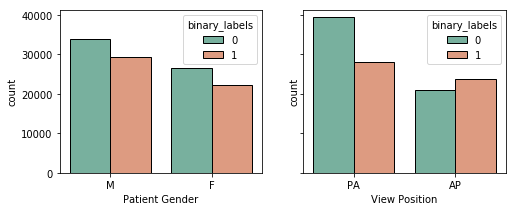

In [6]:
_,axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(8,3))
sns.countplot(data=data_df,
              x='Patient Gender',
              orient='v',
              hue='binary_labels',
              order=None,
              hue_order=None,              
              color=None,
              palette='Set2',
              saturation=0.6,
              edgecolor='black',
              linewidth=1,
              ax=axes[0]) 

sns.countplot(data=data_df,
              x='View Position',
              orient='v',
              hue='binary_labels',
              order=None,
              hue_order=None,              
              color=None,
              palette='Set2',
              saturation=0.6,
              edgecolor='black',
              linewidth=1,
              ax=axes[1]) 

In [7]:
# Code "Patient Gender".
# 0 for female and 1 for male.

data_df['gender'] = data_df['Patient Gender'].apply(lambda x: 0 if (x == 'F') else 1)
data_df['gender'].value_counts()

1    63340
0    48780
Name: gender, dtype: int64

In [8]:
# Code "View Position".
# 0 for "AP" and 1 for "PA".

data_df['position'] = data_df['View Position'].apply(lambda x: 0 if (x == 'AP') else 1)
data_df['position'].value_counts()

1    67310
0    44810
Name: position, dtype: int64

Text(0.5,1,'Age Distribution')

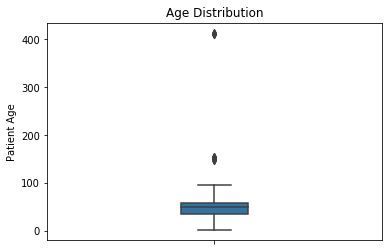

In [9]:
# Boxplot for "Patient Age".
sns.boxplot(data_df['Patient Age'],orient='v',width=0.2)
plt.title('Age Distribution')

In [10]:
# Show those rows with apparently wrong age inputs.

data_df[data_df['Patient Age']>100]

,Image Index,Finding Labels,Follow-up,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage_Width,OriginalImage_Height,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,binary_labels,gender,position
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,1,1,0
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,1,1,0
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,0,1,1
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,0,1,1
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,1,1,1
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,0,1,1
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,1,0,1
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,1,0,1
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,0,1,0
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,1,1,0


In [11]:
data_df['age'] = data_df['Patient Age']

In [12]:
too_old_idx = data_df.index[data_df['age']>100].tolist()
too_old_idx

[20852,
 46965,
 48284,
 55742,
 58650,
 62929,
 74884,
 78795,
 84810,
 85404,
 86264,
 91369,
 95794,
 98495,
 101194,
 104590]

In [13]:
for idx in too_old_idx:
    patient_id = data_df.loc[idx,'Patient ID']
    if len(data_df[data_df['Patient ID'] == patient_id].loc[:,'age']) > 1:
        fixed_age = data_df[data_df['Patient ID']==patient_id].loc[:,'age'].drop(data_df.index[idx]).mean()
        data_df.loc[idx,'age'] = int(fixed_age)

In [14]:
too_old_single_idx = data_df.index[data_df['age']>100].tolist()
too_old_single_idx

[78795, 101194, 104590]

In [15]:
for idx in too_old_single_idx:
    data_df.loc[idx,'age'] = 50

Text(0.5,1,'Age Distribution')

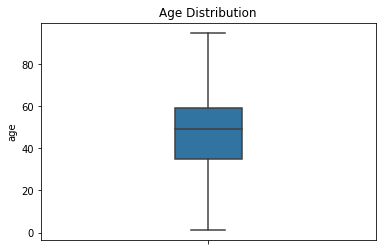

In [16]:
# Boxplot for the fixed age data.

data_df[data_df['age']>100]
sns.boxplot(data_df['age'],orient='v',width=0.2)
plt.title('Age Distribution')

In [17]:
# Statistics for the fixed age data.

data_df[['age']].describe()

,age
count,112120.000000
mean,46.872975
std,16.597885
min,1.000000
25%,35.000000
50%,49.000000
75%,59.000000
max,95.000000


In [47]:
data_df[data_df['Finding Labels'].str.contains('\|') == False].loc[:,'Finding Labels'].value_counts()

No Finding            60361
Infiltration           9547
Atelectasis            4215
Effusion               3955
Nodule                 2705
Pneumothorax           2194
Mass                   2139
Consolidation          1310
Pleural_Thickening     1126
Cardiomegaly           1093
Emphysema               892
Fibrosis                727
Edema                   628
Pneumonia               322
Hernia                  110
Name: Finding Labels, dtype: int64

In [48]:
# Code different types of pathological conditions.

data_df['multi_labels'] = data_df['Finding Labels'].apply(lambda x: 0 if (x == 'No Finding') 
                                                          else 1 if (x == 'Infiltration')
                                                          else 2 if (x == 'Atelectasis')
                                                          else 3 if (x == 'Effusion')
                                                          else 4 if (x == 'Nodule')
                                                          else 5 if (x == 'Pneumothorax')
                                                          else 6 if (x == 'Mass')
                                                          else 7 if (x == 'Consolidation')
                                                          else 8 if (x == 'Pleural_Thickening')
                                                          else 9 if (x in ['Emphysema','Fibrosis','Edema','Pneumonia','Herina'])
                                                          else 10)
                                                        
data_df['multi_labels'].value_counts()

0     60361
10    21999
1      9547
2      4215
3      3955
4      2705
9      2569
5      2194
6      2139
7      1310
8      1126
Name: multi_labels, dtype: int64

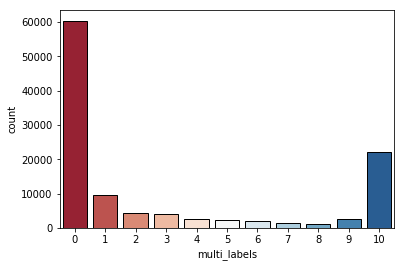

In [53]:
palette = sns.color_palette("RdBu", n_colors=11)
_,ax = plt.subplots(figsize=(6,4))
sns.countplot(data=data_df,
              x='multi_labels',
              orient='v',
              hue=None,
              order=None,
              hue_order=None,              
              color=None,
              palette=palette,
              saturation=0.8,
              edgecolor='black',
              linewidth=1,
              ax=ax)